In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

In [2]:
# hugoferquiroz
work =  Path(r'D:\\Trabajo\AITeacherAllocation')
# Mariadelaguarda
#work =  Path(r'D:\\Trabajo\AITeacherAllocation')

In [3]:
df = pd.read_csv(work/r'Results\\Base consolidada.csv')
df.set_index(['cod_mod','year'],inplace=True)

C:\Users\USUARIO\AppData\Local\Temp\ipykernel_35484\3606240390.py:1: DtypeWarning: Columns (1,122) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(work/r'Results\\Base consolidada.csv')


# Target population

The goal is predict teacher allocation in this population target:

- Educational stage
    - Kindergarten 
    - Primary school

- Teachers:
    - Teachers
    - Education Assistant

- Type of school 
    - Public managed by Central Goverment

In [4]:
# Relevant rows
df = df.loc[df['niv_mod']!='F0'] # Educational stage
df = df.dropna(subset=['region']) # Drop missing in region
df = df.loc[(df['gestion']==1) & (df['ges_dep']=='A1')] # Type of school
df = df.loc[df['estado']==1] # Active in 2022

In [5]:
# Repair educational stage
df.loc[df['d_niv_mod']=='Inicial - Jard¡n','d_niv_mod'] = 'Inicial - Jardin'
df.loc[df['d_niv_mod']=='Inicial - Cuna-jard¡n','d_niv_mod'] = 'Inicial - Cuna-jardin'
# Drop few observations 
df = df.loc[df['d_niv_mod']!='Inicial - Cuna'] # 39 rows deleted
# Drop no relevant information in target variable
df = df.loc[df['secciones_necesarias']!=0] #720 rows deleted

In [6]:
# Drop irrelant columns
df = df.drop(columns=['Unnamed: 0.1','usuario_minedu','bolsa_nexus','bolsa_sira',
'dir_req', 'sub_dir_req','jer_req','fisica_req','aip_req','dir_exd','sub_dir_exd',
'jer_exd','niv_mod','gestion','d_gestion','ges_dep','d_ges_dep','estado',
'd_estado','d_region','tipo_entidad','jec','Unnamed: 0','otro_doc_exd','d_dpto','codlocal','d_dist'])

In [7]:
# Other outcomes not relevant to predict in this version
other_outcomes=['doc_aula_req','aux_req','doc_aula_exd_n', 'doc_aula_exd_c', 'aux_exd']
#df = df.drop(columns=other_outcomes)

# Feature storage 

## Numbers variables

In [8]:
workers = ['dir_n','dir_c','sub_dir_n','sub_dir_c', 'doc_aula_n', 'doc_aula_c', 'otro_doc_n', 'otro_doc_c', 'aux_n', 'aux_c']

In [9]:
enrollment = [x for x in df.columns.to_list() if (x.find('cant')!=-1) or (x.find('inclu')!=-1)]

In [10]:
gps = ['nlat_ie','nlong_ie','ubigeo','codooii']

In [11]:
numerical_inputs = workers+enrollment+gps

In [12]:
workers_stats = df[workers].describe().transpose()

In [13]:
workers_stats['cv'] = workers_stats.iloc[:,2] / workers_stats.iloc[:,1] * 100
workers_stats

,count,mean,std,min,25%,50%,75%,max,cv
dir_n,160087.0,0.131222,0.337644,0.0,0.0,0.0,0.0,1.0,257.307046
dir_c,160087.0,0.049904,0.217748,0.0,0.0,0.0,0.0,1.0,436.331832
sub_dir_n,160087.0,0.022769,0.151782,0.0,0.0,0.0,0.0,2.0,666.619100
sub_dir_c,160087.0,0.013187,0.131522,0.0,0.0,0.0,0.0,5.0,997.390957
doc_aula_n,160087.0,2.332925,4.473909,0.0,0.0,1.0,2.0,66.0,191.772494
doc_aula_c,160087.0,1.055745,1.484930,0.0,0.0,1.0,1.0,27.0,140.652410
otro_doc_n,160087.0,0.058543,0.342958,0.0,0.0,0.0,0.0,7.0,585.820524
otro_doc_c,160087.0,0.125319,0.478971,0.0,0.0,0.0,0.0,8.0,382.200324
aux_n,160087.0,0.063291,0.404233,0.0,0.0,0.0,0.0,12.0,638.693678
aux_c,160087.0,0.150443,0.594403,0.0,0.0,0.0,0.0,15.0,395.101118


## Categorical variables

In [14]:
categorical=['d_niv_mod', 'ruralidad', 'vraem', 'frontera', 'bilingue',
 'caracteristica','d_prov','d_dreugel']

# Train/Test split

In [15]:
inputs = numerical_inputs + categorical

In [16]:
X = df[inputs]
y = df[['secciones_necesarias']]

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2, random_state=36936330)

In [18]:
df_train = pd.merge(X_train,y_train,left_index=True,right_index=True)
df_test = pd.merge(X_test,y_test,left_index=True,right_index=True)

In [19]:
def make_df(df):
    df.reset_index(inplace=True)
    df.drop(columns=['cod_mod','year'],inplace=True)
    return df

In [20]:
df_train = make_df(df_train)
df_test = make_df(df_test)

# Cross validation
Make folds

In [21]:
from sklearn import model_selection

df_train["kfold"] = -1
kf = model_selection.KFold(n_splits=5, shuffle=True, random_state=36936330)
for fold, (train_indicies, valid_indicies) in enumerate(kf.split(X=df_train)):
    df_train.loc[valid_indicies, "kfold"] = fold

In [22]:
df_train.kfold.value_counts()

3    25614
0    25614
1    25614
2    25614
4    25613
Name: kfold, dtype: int64

[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

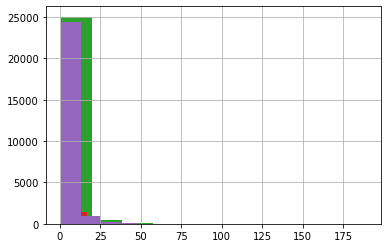

In [23]:
[df_train[df_train.kfold==fold].secciones_necesarias.hist() for fold in range(0,5)]

# Export dataframes

In [24]:
# Local repository
df_train.to_csv(work/r'Results\\df_train.csv')
df_test.to_csv(work/r'Results\\df_test.csv')
# Cloud
df_train.to_csv('D:\\OneDrive\\Trabajo\\Minedu\\AI teacher allocation data\\Results\\df_train.csv')
df_test.to_csv('D:\\OneDrive\\Trabajo\\Minedu\\AI teacher allocation data\\Results\\df_test.csv')